In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import filter_unwanted_seqs

2023-08-27 01:49:03.039112: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 01:49:03.201447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 01:49:03.202613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 01:49:04.168726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reading in esm2 embeddings

In [16]:
def read_data(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv):

    headers = []
    embeddings = []

    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            headers.append(header)
            embeddings.append(np.array(list(emb)))
    print("LOG: ESM2 DONE")

    enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')
    print("LOG: CSV DONE")
    # TODO: Inorder to apply this line of code, I also have to find the corresponding embeddings and 
    #  drop these as well...
    # enzyme_csv = filter_unwanted_seqs(enzyme_csv, True)

    # control
    print(len(embeddings))
    print(len(enzyme_csv))
    print(len(headers))

    return[enzyme_csv, headers, embeddings]

def add_labels(enzymes: pd.DataFrame, entry_ids: list, esm2_emb: list):

    header_labels = {} # dict with → header(id): label (1-7)
    missing_headers = set() # set containing missing headers

    header_to_ec_mapping = {}
    for entry, ec_number in zip(enzymes["Entry"], enzymes["EC number"]):
        header_to_ec_mapping[entry] = ec_number[0]  # Extract the first character

    for header in entry_ids:
        number = enzymes.loc[enzymes["Entry"] == header,"EC number"]
        try:
            ec = int(number.iat[0][0])-1 # since we always start counting from 0
            header_labels[header] = ec
        except IndexError:
            missing_headers.add(header)

    header_label_tuples = [(header, header_labels[header]) for header in entry_ids if header not in missing_headers]

    # Create a new list of embeddings with labels
    embeddings_with_labels = []

    for header, emb in zip(entry_ids, esm2_emb):
        curr_label = next((label for h, label in header_label_tuples if h == header), None)
        if curr_label is not None:
            embeddings_with_labels.append((header, curr_label, emb))

    return embeddings_with_labels


def get_ec_labels(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv) -> pd.DataFrame:
    """
    Adds a label representing the first main ec class (1-7) based on the ec number
    :return: A dataframe containing the corresponding labels
    """

    headers = []
    embeddings = []

    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            headers.append(header)
            embeddings.append(np.array(list(emb)))
    print("LOG: ESM2 DONE")

    enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')
    print("LOG: CSV DONE")
    # TODO: Inorder to apply this line of code, I also have to find the corresponding embeddings and 
    #  drop these as well...
    # enzyme_csv = filter_unwanted_seqs(enzyme_csv, True)

    print(len(embeddings))
    print(len(enzyme_csv))
    print(len(headers))

    header_labels = {} # dict with → header(id): label (1-7)
    missing_headers = set() # set containing missing headers

    header_to_ec_mapping = {}
    for entry, ec_number in zip(enzyme_csv["Entry"], enzyme_csv["EC number"]):
        header_to_ec_mapping[entry] = ec_number[0]  # Extract the first character

    for header in headers:
        number = enzyme_csv.loc[enzyme_csv["Entry"] == header,"EC number"]
        try:
            ec = int(number.iat[0][0])-1 # since we always start counting from 0
            header_labels[header] = ec
        except IndexError:
            missing_headers.add(header)

    header_label_tuples = [(header, header_labels[header]) for header in headers if header not in missing_headers]

    # Create a new list of embeddings with labels
    embeddings_with_labels = []

    for header, emb in zip(headers, embeddings):
        curr_label = next((label for h, label in header_label_tuples if h == header), None)
        if curr_label is not None:
            embeddings_with_labels.append((header, curr_label, emb))

    return embeddings_with_labels


### Creating X and y

In [14]:
enzyme_csv_path = os.getenv("CSV100_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_100")
data = read_data(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)
enzyme_csv = data[0]
entry_ids = data[1]
embeddings = data[2]

embedding_labels = add_labels(enzyme_csv, entry_ids, embeddings)

# embedding_labels = get_ec_labels(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)
X = []
y = []

for label in embedding_labels:
    y.append(label[1]) # append label (1-7)
    X.append(label[2]) # append embedding

LOG: ESM2 DONE
LOG: CSV DONE
7212
7212
7212
    Entry  EC number                                           Sequence
0  C7C422    3.5.2.6  MELPNIMHPVAKLSTALAAALMLSGCMPGEIRPTIGQQMETGDQRF...
1  Q9TTH8  3.4.22.54  MPTVISASVAPRTGAEPRSPGPIAQAAQGKGTEAGGGNPSGIYSAI...
2  Q3TTA7   2.3.2.27  MANSMNGRNPGGRGGNPRKGRILGIIDAIQDAVGPPKQAAADRRTV...
3  P55217   2.5.1.48  MAVSSFQCPTIFSSSSISGFQCRSDPDLVGSPVGGSSRRRVHASAG...
4  D7Y2H2   2.7.7.85  MSTEHVDHKTIARFAEDKVNLPKVKADDFREQAKRLQNKLEGYLSD...
['A0A024RBG1', 'A0A024SMV2', 'A0A096ZEC9', 'A0A0A1H8I4', 'A0A0B0QJN8', 'A0A0B4G504', 'A0A0B5A051', 'A0A0C2SRU5', 'A0A0D1DWQ2', 'A0A0D2YG09', 'A0A0D4BS77', 'A0A0D4BSN8', 'A0A0E3NFS5', 'A0A0F7GG11', 'A0A0H2V871', 'A0A0H2V8B5', 'A0A0H2XEA6', 'A0A0H3GGY3', 'A0A0H3JT80', 'A0A0H3JU78', 'A0A0H3JX98', 'A0A0H3L116', 'A0A0H3L1B8', 'A0A0H3L952', 'A0A0H3M5A8', 'A0A0H5BB17', 'A0A0H5BMX5', 'A0A0K0JFP3', 'A0A0K9RDW0', 'A0A0P9JFY5', 'A0A0R4IKJ1', 'A0A0U1LSP0', 'A0A0U1RQE8', 'A0A0U2UYC4', 'A0A150XSC5', 'A0A151EH88', 'A0A161IUT7', 'A0A1

7212
7212


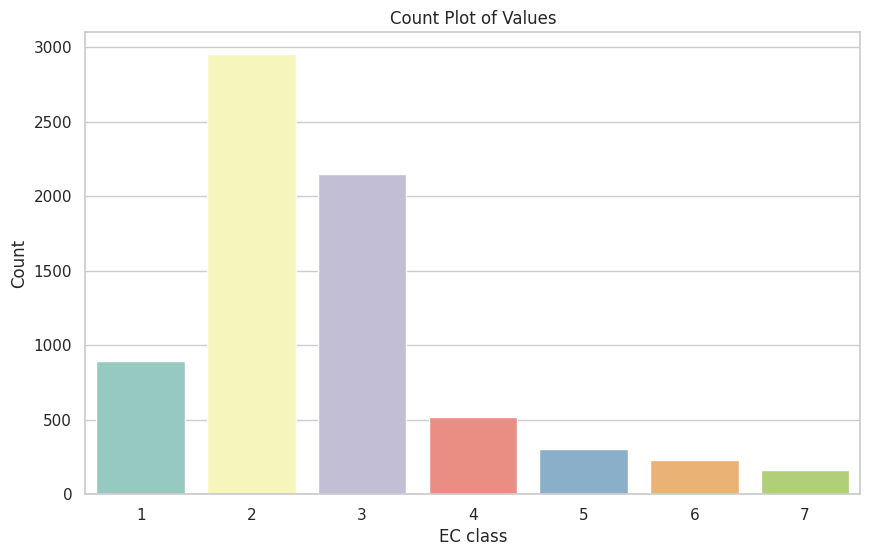

In [15]:
print(len(X))
print(len(y))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Count Plot of Values")

# Show the plot
plt.show()

In [2]:
# Create a DataFrame
df = pd.DataFrame({"feature1":X, "label":y})

# Convert the lists in 'feature1' into separate columns using pd.DataFrame constructor
feature_columns = pd.DataFrame(df["feature1"].tolist(), columns=[f"feature_{i+1}" for i in range(2560)])

# Concatenate the feature columns with the original DataFrame
df = pd.concat([df.drop("feature1", axis=1), feature_columns], axis=1)

# Display the resulting DataFrame
print(df.head())


NameError: name 'pd' is not defined

In [1]:
df.to_csv("/home/malte/Desktop/ann_esm2_ml_df.csv", sep=";")

NameError: name 'df' is not defined

In [ ]:

X = df.drop('label', axis=1).values
y = df['label'].values



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)


In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)


In [ ]:
len(X_train[0])

In [ ]:
earl_stop = tf.keras.callbacks.EarlyStopping(patience=50)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification
# model.add(
#     tf.keras.layers.Dense(units=2560, activation="relu", input_shape=(2560,))
# )
# 
# model.add(
#     tf.keras.layers.Dense(units=15, activation="relu")
# )
# 
# model.add(
#     tf.keras.layers.Dense(units=7, activation='softmax') # da classification
# )

model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
model.fit(x=X_train, y=y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

In [ ]:
model_loss = pd.DataFrame(model.history.history)

model_loss.plot() # early stopping where plot diverges


In [ ]:
predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)

In [ ]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print(counter)
print(len(y_test))

In [ ]:
report = classification_report(y_test, predictions)

class_0_metrics = report.split('\n')[3].split()[1:]
class_1_metrics = report.split('\n')[4].split()[1:]
class_2_metrics = report.split('\n')[5].split()[1:]
class_3_metrics = report.split('\n')[6].split()[1:]
class_4_metrics = report.split('\n')[7].split()[1:]
class_5_metrics = report.split('\n')[8].split()[1:]
class_6_metrics = report.split('\n')[9].split()[1:]

metrics = [class_0_metrics,
           class_1_metrics,
           class_2_metrics,
           class_3_metrics,
           class_4_metrics,
           class_5_metrics,
           class_6_metrics
           ]
i = 1
for class_m in metrics:
    accuracy = float(class_0_metrics[0])
    precision = float(class_0_metrics[1])
    recall = float(class_0_metrics[2])
    f1_score = float(class_0_metrics[3])
    print(f"Accuracy for class {i}: {accuracy}")
    print(f"Precision for class {i}: {precision}")
    print(f"Recall for class {i}: {recall}")
    print(f"F1-score for class {i}: {f1_score}")
    i+=1
print(report)

In [ ]:
print(confusion_matrix(y_test, predictions))


In [ ]:
model.save("initial_ann_v2_70_acc88")

def nget_ec_labels(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv) -> pd.DataFrame:
    """
    Adds a label representing the first main ec class (1-7) based on the ec number
    :return: A dataframe containing the corresponding labels
    """

    headers = []
    embeddings = []

    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            headers.append(header)
            embeddings.append(np.array(list(emb)))

    enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')
    # TODO: Inorder to apply this line of code, I also have to find the corresponding embeddings and 
    #  drop these as well...
    # enzyme_csv = filter_unwanted_seqs(enzyme_csv, True)

    print(len(embeddings))
    print(len(enzyme_csv))

    header_labels = {} # dict with → header(id): label (1-7)

    header_to_ec_mapping = {}
    for entry, ec_number in zip(enzyme_csv["Entry"], enzyme_csv["EC number"]):
        header_to_ec_mapping[entry] = ec_number[0]  # Extract the first character

    for header in headers:
        number = enzyme_csv.loc[enzyme_csv["Entry"] == header,"EC number"]
        if number is not None:
            ec = int(number.iat[0][0])-1 # since we always start counting from 0
            header_labels[header] = ec

    header_label_tuples = [(header, header_labels[header]) for header in headers]

    # Create a new list of embeddings with labels
    embeddings_with_labels = []

    for header, emb in zip(headers, embeddings):
        curr_label = next((label for h, label in header_label_tuples if h == header), None)
        if curr_label is not None:
            embeddings_with_labels.append((header, curr_label, emb))

    return embeddings_with_labels
